# End to end learning with closed form solution

**2-stage Method vs. e2e with fair constraints vs. fair objectives**

1. Create a dataset

2. Optimization model

4. Training
    - with different loss functions

5. Evaluation

In [13]:
import cvxpy as cp
import numpy as np
import time
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

warnings.filterwarnings("ignore")
np.printoptions(suppress=True)
InteractiveShell.ast_node_interactivity = "all"
sys.path.insert(1,'E:\\User\\Stevens\\Spring 2024\\PTO - Fairness\\myUtils')

from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Generate synthetic data
from genData import genData
from optDataset import AlphaFairOptDataset
from optModel import optCvModel


In [14]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
%%capture
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Now import the necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
from genData import genData
from optDataset import AlphaFairOptDataset

num_data = 1000
num_features = 10
num_items = 5
a, b, c, r, x, Q, epsilon = genData(num_data, num_features, num_items)

# Create dataset
dataset = AlphaFairOptDataset(a, b, c, r, x, Q, alpha=0.5, epsilon=epsilon)

# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
batch_size = 32
loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_items)

    def forward(self, x):
        return self.linear(x)

# Initialize model, loss function, and optimizer
input_dim = num_features
model = LogisticRegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Define the regret loss function
def regret(predmodel, optmodel, dataloader):
    predmodel.eval()
    loss = 0
    optsum = 0

    for data in dataloader:
        x, _, _, _ = data
        x = x.float()
        with torch.no_grad():
            r_hat = predmodel(x).numpy()
        
        for i in range(len(x)):
            optmodel.setObj(a[i], r_hat[i], b[i], c[i])
            u_opt, d_opt, opt_value_pred = optmodel.solveP()
            u_true, d_true, opt_value_true = optmodel.solve()
            loss += abs(opt_value_true - opt_value_pred)
            optsum += abs(opt_value_true)

    return loss / (optsum + 1e-7)

# Training process
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for data in loader_train:
        x, _, _, r_true = data
        x = x.float()
        r_true = r_true.float()
        optimizer.zero_grad()
        r_hat = model(x)
        loss = criterion(r_hat, r_true)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(loader_train))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(loader_train):.4f}')




Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training Loss Curve')

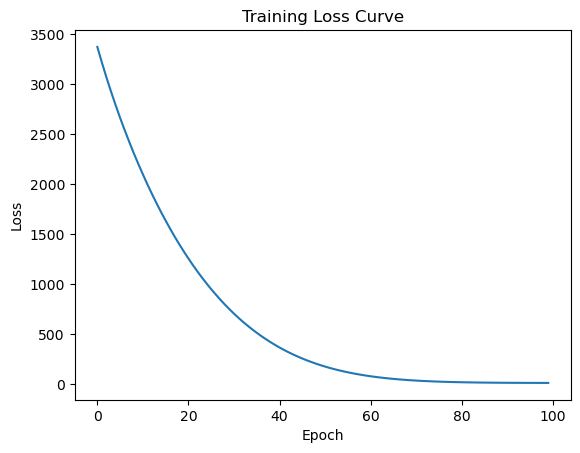

In [16]:
# Plot the loss curve
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [1]:
import numpy as np

def check_matrix_conditions_with_lambda_zero(A, B, C, D, M):
    # Lambda is zero
    Lambda = np.zeros((n**2, n**2))
    
    # Construct the LHS block matrix
    LHS = np.block([
        [A, B, C],
        [Lambda, D, np.zeros((n**2, n))],
        [M, np.zeros((n, n**2)), (np.sum(c * d_i) - Q) * np.eye(n)]
    ])

    # Check conditions for invertibility
    def is_invertible(matrix):
        return np.linalg.cond(matrix) < 1 / np.finfo(matrix.dtype).eps

    is_invertible_LHS = is_invertible(LHS)
    condition_number = np.linalg.cond(LHS)

    return {
        "is_invertible_LHS": is_invertible_LHS,
        "condition_number": condition_number
    }

# Example data
a = np.array([0.66748258, 0.60456784])
b = np.array([1.11949035, 0.96349404])
c = np.array([8., 7.])
r = np.array([0.02581191, 0.13516629])
Q = 1000
epsilon = 0.1
alpha = 0.5
d_i = np.array([0.5, 0.5])
lambda_i = np.array([0.0, 0.0])  # Lambda is zero
mu = 1
n = len(a)

# Construct matrices (same as before)
A_elements = [alpha * b[i]**2 * (a[i] * r[j] + b[i] * d_i[i] + epsilon)**(-alpha-1) for i in range(n) for j in range(n)]
A = np.diag(A_elements)
B = -np.eye(n**2)
C = np.zeros((n**2, n))
for i in range(n):
    for j in range(n):
        idx = i * n + j
        C[idx, i] = c[i]
D = np.zeros((n**2, n**2))
for i in range(n):
    for j in range(n):
        idx = i * n + j
        D[idx, idx] = d_i[i]
M = np.zeros((n, n**2))
for i in range(n):
    M[i, i * 2] = mu * c[i]
    M[i, i * 2 + 1] = mu * c[i]

# Check conditions with lambda = 0
conditions_with_lambda_zero = check_matrix_conditions_with_lambda_zero(A, B, C, D, M)
for key, value in conditions_with_lambda_zero.items():
    print(f"{key}: {value}")


is_invertible_LHS: True
condition_number: 3100.0430504262117


In [2]:
import numpy as np

def check_singularity_with_zero_lambda(A, B, C, D, M):
    # Lambda is zero
    Lambda = np.zeros((n**2, n**2))
    
    # Construct the LHS block matrix
    LHS = np.block([
        [A, B, C],
        [Lambda, D, np.zeros((n**2, n))],
        [M, np.zeros((n, n**2)), (np.sum(c * d_i) - Q) * np.eye(n)]
    ])

    # Check conditions for invertibility
    def is_invertible(matrix):
        return np.linalg.cond(matrix) < 1 / np.finfo(matrix.dtype).eps

    is_invertible_LHS = is_invertible(LHS)
    condition_number = np.linalg.cond(LHS)

    return {
        "is_invertible_LHS": is_invertible_LHS,
        "condition_number": condition_number,
        "rank": np.linalg.matrix_rank(LHS),
        "LHS": LHS
    }

# Example data
a = np.array([0.66748258, 0.60456784])
b = np.array([1.11949035, 0.96349404])
c = np.array([8., 7.])
r = np.array([0.02581191, 0.13516629])
Q = 1000
epsilon = 0.1
alpha = 0.5
d_i = np.array([0.5, 0.5])
lambda_i = np.array([0.0, 0.0])  # Lambda is zero
mu = 1
n = len(a)

# Construct matrices (same as before)
A_elements = [alpha * b[i]**2 * (a[i] * r[j] + b[i] * d_i[i] + epsilon)**(-alpha-1) for i in range(n) for j in range(n)]
A = np.diag(A_elements)
B = -np.eye(n**2)
C = np.zeros((n**2, n))
for i in range(n):
    for j in range(n):
        idx = i * n + j
        C[idx, i] = c[i]
D = np.zeros((n**2, n**2))
for i in range(n):
    for j in range(n):
        idx = i * n + j
        D[idx, idx] = d_i[i]
M = np.zeros((n, n**2))
for i in range(n):
    M[i, i * 2] = mu * c[i]
    M[i, i * 2 + 1] = mu * c[i]

# Check conditions with lambda = 0
conditions_with_lambda_zero = check_singularity_with_zero_lambda(A, B, C, D, M)
for key, value in conditions_with_lambda_zero.items():
    print(f"{key}: {value}")

# Examine the matrix structure
LHS = conditions_with_lambda_zero['LHS']
print("LHS Matrix:\n", LHS)


is_invertible_LHS: True
condition_number: 3100.0430504262117
rank: 10
LHS: [[ 1.12500010e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
   8.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.64823946e-01  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -1.00000000e+00 -0.00000000e+00 -0.00000000e+00
   8.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00536210e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -1.00000000e+00 -0.00000000e+00
   0.00000000e+00  7.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.58898446e-01
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e+00
   0.00000000e+00  7.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.000